In [3]:
#%%capture

#!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'
#!pip install transformers
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime
#from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
#from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from fhnw.nlp.utils.preprocess import preprocess
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score ,precision_score, make_scorer, recall_score
tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


Laden der Daten

In [4]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)


data_train["split"] = "train"
data_test["split"] = "test"
data_all = pd.concat([data_train, data_test])
data = data_train

In [5]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_code = le.fit(data_train['label'].drop_duplicates())
#y_train 

In [7]:
label = pd.DataFrame(data_train['label'].drop_duplicates(inplace=False))
label.reset_index(inplace = True, drop = True)
label

,label
0,Sport
1,Kultur
2,Web
3,Wirtschaft
4,Inland
5,Etat
6,International
7,Panorama
8,Wissenschaft


Vorbereiten der Daten und kurzer check der längen.

In [8]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation"""



    # Compile RE pattern for HTTPS address, then Substitute it for blank
    RE_HTTPS = re.compile(r"https?://\S+ ")
    text = re.sub(RE_HTTPS, "", text)

    # Subsitute twitter picutures for blank
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)

    # Subsitute multiple points space for 1 point
    text = re.sub(r"\(?[.][.]+\)?", ".", text)

    # Compile RE pattern for HTML tags, then Substitute it for blank
    RE_TAGS = re.compile(r"<[^>]+>")
    text = re.sub(RE_TAGS, " ", text)

    # Compile RE patterns for general text, including punctuation rule
    if keep_punctuation:
        RE_ASCII = re.compile(r"[^a-züöä,.!?]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[a-züöä,.!?]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    # convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_SINGLECHAR, " ", text)

    # Subsitute multiple blank space for 1 blank space
    text = re.sub(r"\s+", " ", text)

    # Subsitute double punctuation (left-over after previous subsitutions) for 1 point
    text = re.sub(r" [.,]+ [,.]+", ".", text)

    return text

In [9]:
X_train = data['text_original'] #.apply(clean_text, keep_punctuation = True) -> getestet, gibt schlechtere Resultate
X_test = data_test['text_original'] #.apply(clean_text, keep_punctuation = True)-> getestet, gibt schlechtere Resultate
y_train = label_code.transform(data['label'])
y_true = label_code.transform(data_test['label'])
print(len(y_train),len(y_true), len(X_test))


9245 1028 1028


# Tensorflow Regulate

In [10]:
vocab_size = 10000
BATCH_SIZE = 16
EPOCHS = 8
LEARNING_RATE = 1e-5
NEURON = 2**5
l2_reg = 1e-3
DROP = .5


In [11]:
tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
)

count_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='count'
)

count_vectorizer.adapt(X_train.values)

"""
tfidf_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf-idf',
    ngrams=(2, 3)
)
tfidf_vectorizer.adapt(X_train.values)
# Define the neural network architecture
model = tf.keras.Sequential([
    tfidf_vectorizer,
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
"""

"\ntfidf_vectorizer = tf.keras.layers.TextVectorization(\n    max_tokens=vocab_size,\n    output_mode='tf-idf',\n    ngrams=(2, 3)\n)\ntfidf_vectorizer.adapt(X_train.values)\n# Define the neural network architecture\nmodel = tf.keras.Sequential([\n    tfidf_vectorizer,\n    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),  # Hidden layer with ReLU activation\n    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification\n])\n\n# Compile the model\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\nmodel.summary()\n"

In [12]:
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
                    .shuffle(buffer_size=len(X_train.values), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test.values, y_true))
                    .batch(BATCH_SIZE))

In [13]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
y_true=label_binarizer.transform(data_test['label'])

In [14]:
from tensorflow.keras import regularizers



# Build the model
def create_model(NEURON,DROP,l2_reg,vocab_size):
    model = tf.keras.Sequential([
        count_vectorizer,
        tf.keras.layers.Dense(2*NEURON, activation='relu', input_shape=(vocab_size,), kernel_regularizer=regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(DROP),  # Adding dropout for regularization
        tf.keras.layers.Dense(NEURON, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(DROP),
        tf.keras.layers.Dense(NEURON, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(DROP),
        tf.keras.layers.Dense(NEURON//2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        tf.keras.layers.Dropout(DROP),
        tf.keras.layers.Dense(9, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Compile the model
    model.summary()
    return model



In [15]:
model = create_model(NEURON,DROP,l2_reg,vocab_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 10000)             0         
 Vectorization)                                                  
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                        

In [18]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=int(1.5*EPOCHS),
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="accuracy", verbose=1, patience=2, restore_best_weights=True)
    ],
)

Epoch 1/12
4623/4623 [==============================] - 50s 11ms/step - loss: 1.9170 - accuracy: 0.3270 - val_loss: 1.5461 - val_accuracy: 0.5000
Epoch 2/12
4623/4623 [==============================] - 63s 14ms/step - loss: 1.6617 - accuracy: 0.4294 - val_loss: 1.4917 - val_accuracy: 0.5224
Epoch 3/12
4623/4623 [==============================] - 60s 13ms/step - loss: 1.6375 - accuracy: 0.4377 - val_loss: 1.5637 - val_accuracy: 0.4844
Epoch 4/12
4623/4623 [==============================] - 70s 15ms/step - loss: 1.6305 - accuracy: 0.4400 - val_loss: 1.5397 - val_accuracy: 0.5117
Epoch 5/12
4623/4623 [==============================] - 66s 14ms/step - loss: 1.6311 - accuracy: 0.4421 - val_loss: 1.5577 - val_accuracy: 0.5088
Epoch 6/12
4623/4623 [==============================] - 59s 13ms/step - loss: 1.6307 - accuracy: 0.4414 - val_loss: 1.5698 - val_accuracy: 0.5088
Epoch 7/12
4623/4623 [==============================] - 57s 12ms/step - loss: 1.6234 - accuracy: 0.4449 - val_loss: 1.5763 -

<AxesSubplot: xlabel='epoch'>

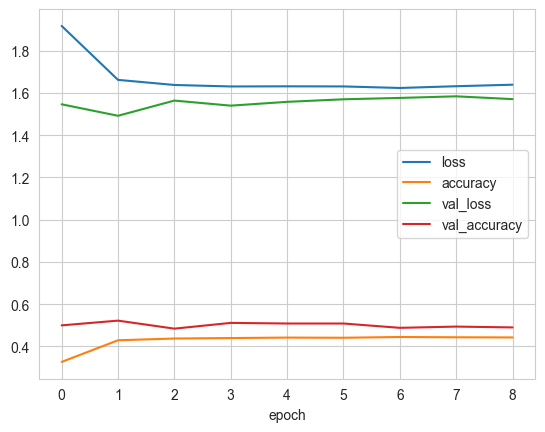

In [19]:
history_df = pd.DataFrame({'epoch': history.epoch, **history.history}).set_index('epoch')
history_df.plot()

In [ ]:
result = model.predict(X_test.values)
result = result > .5
y_pred = result.astype(int)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

33/33 [==============================] - 1s 10ms/step
Accuracy: 0.48249027237354086
F1-Score: 0.41475819598988584
Recall: 0.37446264275910607
Precision: 0.46762209904063506


c:\Users\reto.steiner\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fazit
Regularisierung zu stark. Tune das Modell mit Gridsearch im nächsten Notebook. Rechenaufwand wird gross.